In [45]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tor_model import Unet

In [2]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
print(device)

cuda


### **1. Data Loader**

In [3]:
class LoadData(Dataset):
    def __init__(self, ds_dir):
        self.ds_dir = ds_dir
        self.image_paths, self.mask_paths = self._process_data_path()
        self.length = len(self.image_paths)
    
    def __len__(self):
        return self.length
    
    def _process_data_path(self):
        image_paths = []
        mask_paths = []
        for image_file in os.listdir(self.ds_dir + '/images'):
            image_paths.append(os.path.join(self.ds_dir, 'images', image_file))
        for mask_file in os.listdir(self.ds_dir + '/masks'):
            mask_paths.append(os.path.join(self.ds_dir, 'masks', mask_file))
        return image_paths, mask_paths
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]
        
        image = torch.tensor(np.array(Image.open(image_path))).unsqueeze(0)
        mask = torch.tensor(np.array(Image.open(mask_path))).unsqueeze(0)
        
        return {
            'image_path': image_path,
            'mask_path': mask_path,
            'image': image / 255.0,
            'mask': mask
        }

In [4]:
train_ds = LoadData('../data/Sandstone/train')
val_ds = LoadData('../data/Sandstone/val')
test_ds = LoadData('../data/Sandstone/test')

print(len(train_ds), len(val_ds), len(test_ds))

205 26 25


In [5]:
print(val_ds[20]['image'].size())

torch.Size([1, 256, 256])


In [8]:
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    # num_workers=2,
    # prefetch_factor=2,
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=True,
    # num_workers=2,
    # prefetch_factor=2,
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=True,
    # num_workers=2,
    # prefetch_factor=2,
)

len(train_loader), len(val_loader), len(test_loader)

(205, 26, 25)

### **2. Training**

In [34]:
x = torch.randint(low=0, high=1, size=((1, 1, 256, 256)), dtype=torch.float32)
x = x.to(device)
model = Unet().to(device)
y_logits = model(x)
print(y_logits.shape)

torch.Size([1, 4, 256, 256])


In [39]:
_, pred = torch.max(y_logits, dim=1)
y_true = pred

print(y_logits.dtype, y_true.dtype)
print(y_logits.size(), y_true.size())

ce_loss = nn.CrossEntropyLoss()
loss = ce_loss(y_logits, y_true)
print(loss)

torch.float32 torch.int64
torch.Size([1, 4, 256, 256]) torch.Size([1, 256, 256])
tensor(0.9080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


In [28]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_logits, y_true, smooth=1.):
        _, y_logits = torch.max(y_logits, dim=0)
        
        y_logits = y_logits.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_logits * y_true).sum()
        return 1 -  ((2.*intersection + smooth) / (y_logits.sum() + y_true.sum() + smooth))
    
dice_loss = DiceLoss()
print(dice_loss(y_logits.squeeze(0), y_true.to(device).squeeze(0)))

tensor(-0.8813, device='cuda:0')


In [25]:
ce_loss = nn.CrossEntropyLoss()
model = Unet().to(device)
sgd = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
EPOCHS = 20
train_steps = len(train_loader)
val_steps = len(val_loader)
train_loss = []
val_loss = []

def TrainingLoop():
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}:')
        
        model.train()
        cur_train_loss = 0
        for batch in train_loader:
            # 1. Reset
            sgd.zero_grad()

            # 2. Feed forward
            input = batch['image'].to(device)
            y_true = batch['mask'].squeeze(0).to(torch.int64).to(device)
            y_logits = model(input)
             
            # 3. Compute loss
            loss = ce_loss(y_logits, y_true)
            cur_train_loss += loss.item()

            # 4. Backpropagation
            loss.backward()
            sgd.step()
        
        model.eval()
        cur_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input = batch['image'].to(device)
                y_true = batch['mask'].squeeze(0).to(torch.int64).to(device)
                y_logits = model(input)
                loss = ce_loss(y_logits, y_true)
                cur_val_loss += loss.item()
                
        tr_loss, vl_loss = cur_train_loss / train_steps, cur_val_loss / val_steps
        train_loss.append(tr_loss)
        val_loss.append(vl_loss)
        print(f"Train loss: {tr_loss}  Validation loss: {vl_loss}")
        
TrainingLoop()

In [42]:
torch.save(model, '../models/unet_sandstone_20_ce_direct_torch.pth')

In [46]:
# Define the file name
file_name = f'../results/unet_sandstone_20_ce_direct_torch.csv'

# Writing the data into a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])
    for epoch in range(len(train_loss)):
        writer.writerow([epoch+1, train_loss[epoch], val_loss[epoch]])

print(f"Training history has been saved to {file_name}")

Training history has been saved to ../results/unet_sandstone_20_ce_direct_torch.csv


### **3. Visualize**

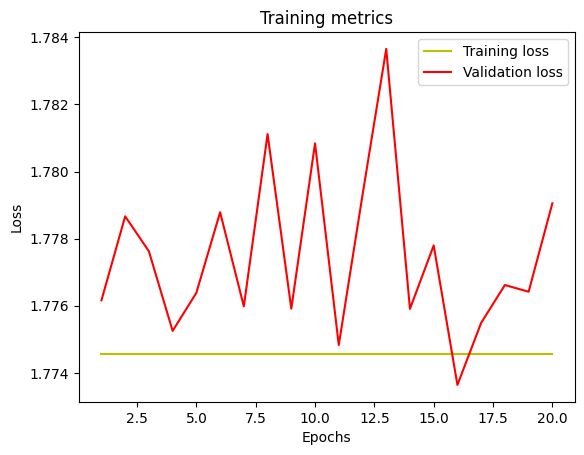

<Figure size 640x480 with 0 Axes>

In [41]:
def visualize(epochs, scores_1, scores_2, legend_1, legend_2, x_label, y_label, title, filename):
    plt.plot(epochs, scores_1, 'y', label=legend_1)
    plt.plot(epochs, scores_2, 'r', label=legend_2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    plt.savefig(f'../graphs/{filename}')

visualize(
    list(range(1,(len(train_loss)+1))),
    train_loss, val_loss,
    'Training loss', 'Validation loss',
    'Epochs', 'Loss',
    'Training metrics', 'unet_sand_stone_20_ce_loss_torch.png'
)

In [68]:
loaded_model = torch.load('../models/unet_sandstone_20_ce_direct_torch.pth')

In [69]:
image_path = "../data/Sandstone/train/images/image_0054.png"
mask_path = "../data/Sandstone/train/masks/mask_0054.png"
image = torch.tensor(np.array(Image.open(image_path)) / 255.0 ).unsqueeze(0).unsqueeze(0).to(torch.float32).to(device)
mask = torch.tensor(np.array(Image.open(mask_path))).to(torch.int64).unsqueeze(0).to(device)

image.size(), mask.size()

(torch.Size([1, 1, 256, 256]), torch.Size([1, 256, 256]))

In [70]:
y_logits = loaded_model(image)
print(ce_loss(y_logits, mask))

tensor(1.7993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


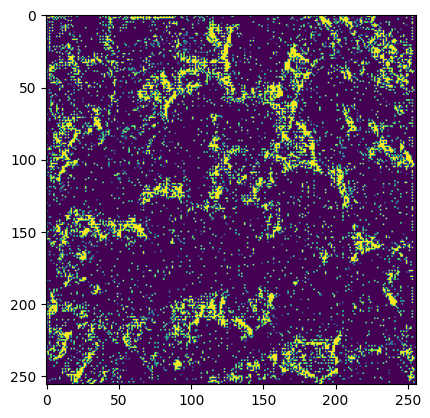

In [71]:
_, pred = torch.max(y_logits, dim=1)
plt.imshow(pred.squeeze(0).detach().cpu().numpy())

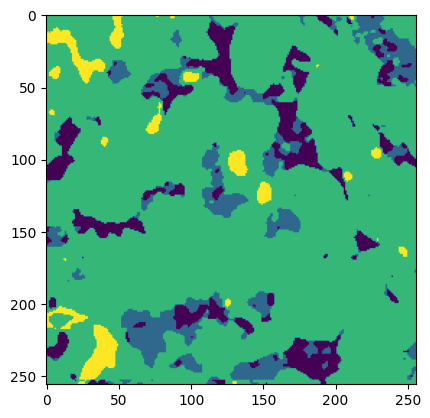

In [72]:
plt.imshow(mask.squeeze(0).detach().cpu().numpy())